<a href="https://colab.research.google.com/github/josephxlp/SHORT_PROJECTS/blob/main/CropHealthTAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install rasterio rasterstats -q

In [9]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [10]:
datapath= "/content/drive/MyDrive/PROJx/data/GeoML/crop_data/"
os.chdir(datapath)

In [12]:
# Open the raster files using context managers
with rasterio.open('data/dem.tif') as dem, \
     rasterio.open('data/ortho.tif') as ortho, \
     rasterio.open('data/dtm.tif') as dtm:

    # Read the data into arrays
    dem_arr = dem.read(1)
    ortho_arr = ortho.read([1, 2, 3, 4, 5, 6])  # R, G, B, NIR, RedEdge, Thermal
    dtm_arr = dtm.read(1)


In [13]:
plots_1 = gpd.read_file('data/plots_1.shp')
plots_2 = gpd.read_file('data/plots_2.shp')

In [14]:
elevation = np.where(dem_arr <= 0, np.nan, dem_arr)
masked_thermal = np.where(ortho_arr[5] <= 0, np.nan, ortho_arr[5] / 100 - 273.15)  # Convert to Celsius

In [17]:
# Generate NDVI (Normalized Difference Vegetation Index) with error handling
# NDVI = (NIR - Red) / (NIR + Red)
with np.errstate(divide='ignore', invalid='ignore'):
    ndvi = (ortho_arr[3] - ortho_arr[0]) / (ortho_arr[3] + ortho_arr[0])
    ndvi = np.where(np.isnan(ndvi), 0, ndvi)

In [18]:
def compute_zonal_stats(plots, data, affine):
    import rasterstats as rs
    plot_zs = rs.zonal_stats(plots, data, affine=affine, stats="mean", nodata=np.nan, geojson_out=True)
    return gpd.GeoDataFrame.from_features(plot_zs)

In [19]:
# Calculate mean NDVI, thermal, elevation, and DTM values for each plot
plots_1['NDVI_mean'] = compute_zonal_stats(plots_1, ndvi, dem.transform)['mean']
plots_1['thermal_mean'] = compute_zonal_stats(plots_1, masked_thermal, dem.transform)['mean']
plots_1['elevation_mean'] = compute_zonal_stats(plots_1, elevation, dem.transform)['mean']
plots_1['dtm_mean'] = compute_zonal_stats(plots_1, dtm_arr, dem.transform)['mean']

In [20]:
plots_1.head()

,NAME,LAYER,MAP_NAME,geometry,NDVI_mean,thermal_mean,elevation_mean,dtm_mean
0,2,Coverage/Quad,User Created Features,"POLYGON Z ((289583.708 5130289.226 0, 289588.7...",0.438559,28.059842,363.717766,362.185250
1,3,Coverage/Quad,User Created Features,"POLYGON Z ((289588.705 5130289.052 0, 289593.7...",0.445282,26.597221,363.811965,362.165315
2,4,Coverage/Quad,User Created Features,"POLYGON Z ((289593.702 5130288.877 0, 289598.6...",0.552864,27.543570,364.005800,362.121171
3,5,Coverage/Quad,User Created Features,"POLYGON Z ((289598.699 5130288.703 0, 289603.6...",0.530295,24.495659,365.031981,362.062528
4,6,Coverage/Quad,User Created Features,"POLYGON Z ((289603.696 5130288.528 0, 289608.6...",0.536660,23.950518,365.145092,361.989222


In [21]:
# Data preparation
# Drop NaN values and prepare feature matrix for model training
plots_1 = plots_1.dropna()
features = plots_1[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]

In [22]:
# Create a synthetic target variable focusing on healthy crops
# Define healthy crops based on NDVI values between 0.4 and 0.8
healthy_mask = (plots_1['NDVI_mean'] >= 0.4) & (plots_1['NDVI_mean'] <= 0.8)
plots_1['synthetic_target'] = np.where(healthy_mask, 1, 0)  # Healthy crops = 1, Others = 0

In [23]:
# Check data balance
# Print class distribution to check for imbalance
class_counts = plots_1['synthetic_target'].value_counts()
print(f"Class distribution:\n{class_counts}")

# Handle data imbalance by undersampling the majority class
from sklearn.utils import resample

# Separate majority and minority classes
# This variable indicates whether a crop is healthy (1) or not (0).
minority_class = plots_1[plots_1['synthetic_target'] == 1]
majority_class = plots_1[plots_1['synthetic_target'] == 0]

# Resample majority class to match the minority class size
majority_class_downsampled = resample(majority_class,
                                      replace=False,
                                      n_samples=len(minority_class),
                                      random_state=42)
balanced_data = pd.concat([minority_class, majority_class_downsampled])

# Reassign features and target from the balanced data
features = balanced_data[['NDVI_mean', 'thermal_mean', 'elevation_mean', 'dtm_mean']]
target = balanced_data['synthetic_target']

Class distribution:
synthetic_target
0    78
1    54
Name: count, dtype: int64


In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [25]:
# Standardize data
# Standardize features to have zero mean and unit variance
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid activation function for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with the callbacks
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr]
)


In [28]:
# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy}")

# Make predictions
# Predict the class labels for the test set
predictions = (model.predict(X_test) > 0.5).astype("int32")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9545 - loss: 0.1599
Accuracy on test data: 0.9545454382896423
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step


In [29]:
# Calculate evaluation metrics:
# Compute accuracy, precision, recall, F1 score, and ROC AUC score
accuracy_score_val = accuracy_score(y_test, predictions)
precision_score_val = precision_score(y_test, predictions)
recall_score_val = recall_score(y_test, predictions)
f1_score_val = f1_score(y_test, predictions)
roc_auc_score_val = roc_auc_score(y_test, model.predict(X_test))

print(f"Accuracy Score: {accuracy_score_val}")
print(f"Precision Score: {precision_score_val}")
print(f"Recall Score: {recall_score_val}")
print(f"F1 Score: {f1_score_val}")
print(f"ROC AUC Score: {roc_auc_score_val}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Accuracy Score: 0.9545454545454546
Precision Score: 1.0
Recall Score: 0.9
F1 Score: 0.9473684210526315
ROC AUC Score: 1.0


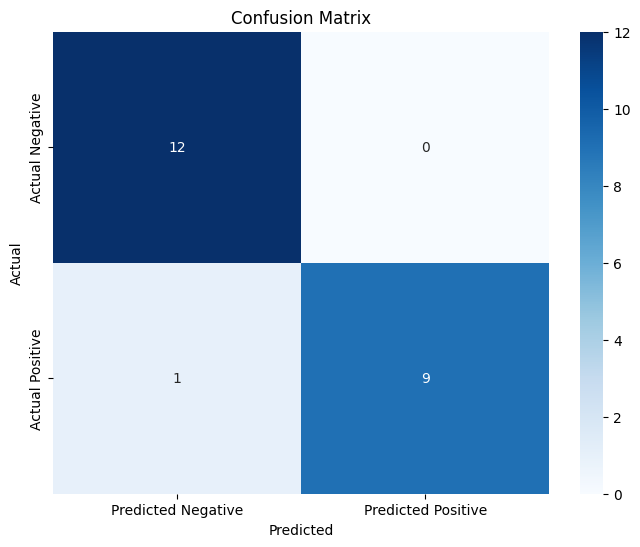

In [30]:
# Plot the confusion matrix to visualize model performance
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()